In [63]:
import sys
sys.path.append('../algorithms')

from misra_gries import MisraGries
from count_min_sketch import CountMinSketch
from count_sketch import BasicCountSketch
from count_median import CountSketchMedian
from generate_stream import generate_stream
from collections import Counter
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# config
stream_length = 10000
item_pool = 100
distribution = 'uniform'
k = 50
width = 20
depth = 5

# stream, true counts
stream = generate_stream(distribution, length=stream_length, item_pool=item_pool)
true_counts = Counter(stream)
unique_items = set(stream)

# --- Algorithm Configurations ---
algorithms = {
    "MisraGries": lambda: MisraGries(k),
    "CountMinSketch": lambda: CountMinSketch(width, depth),
    "CountSketch": lambda: BasicCountSketch(width),
    "CountMedian": lambda: CountSketchMedian(width, depth),
}

# --- Run and Time Each Algorithm ---
results = {}

for name, constructor in algorithms.items():
    algo = constructor()
    start = time.time()
    for item in stream:
        algo.update(item)
    runtime = time.time() - start

    estimates = {item: algo.estimate(item) for item in unique_items}
    results[name] = {
        "estimates": estimates,
        "runtime": runtime,
    }

In [2]:
def compute_errors(estimated, true_counts):
    errors = {}
    for item in true_counts:
        true = true_counts[item]
        est = estimated.get(item, 0)
        abs_error = abs(est - true)
        rel_error = abs_error / true if true != 0 else 0
        errors[item] = (true, est, abs_error, rel_error)
    return errors

for algo, result in results.items():
    result['errors'] = compute_errors(result['estimates'], true_counts)


In [57]:
def compute_error_bounds(dist, true_counts, estimates_dict, epsilon, algorithm):
    df = []
    items = list(true_counts.keys())

    for item in items:
        true_val = true_counts[item]
        est_val = estimates_dict.get(item, 0)
        error = est_val - true_val
        abs_error = abs(error)

        # L1 and L2 norms excluding current item
        L1_ = sum(v for k, v in true_counts.items() if k != item)
        L2_ = np.sqrt(sum(v ** 2 for k, v in true_counts.items() if k != item))

        if algorithm in ["MisraGries", "CountMinSketch", "CountMedian"]:
            bound = epsilon * L1_
        elif algorithm == "CountSketch":
            bound = epsilon * L2_
        else:
            bound = None

        fits = abs_error <= bound

        df.append({
            "Algorithm": algorithm,
            "Distribution": dist,
            "Item": item,
            "TrueCount": true_val,
            "Estimate": est_val,
            "AbsError": abs_error,
            "TheoreticalBound": round(bound, 2),
            "WithinBound": fits
        })

    return pd.DataFrame(df)


In [58]:
epsilon = 1 / 50  
all_dfs = []
distributions = ['uniform', 'zipf', 'bursty']
for distribution in distributions:
    stream = generate_stream(distribution, length=stream_length, item_pool=item_pool)
    true_counts = Counter(stream)
    unique_items = set(stream)
    for alg in algorithms:
        df = compute_error_bounds(distribution, true_counts, results[alg]['estimates'], epsilon, alg)
        all_dfs.append(df)

full_df = pd.concat(all_dfs, ignore_index=True)
full_df

,Algorithm,Distribution,Item,TrueCount,Estimate,AbsError,TheoreticalBound,WithinBound
0,MisraGries,uniform,81,111,3,108,197.78,True
1,MisraGries,uniform,14,103,0,103,197.94,True
2,MisraGries,uniform,3,87,1,86,198.26,True
3,MisraGries,uniform,94,103,0,103,197.94,True
4,MisraGries,uniform,35,100,0,100,198.00,True
...,...,...,...,...,...,...,...,...
1195,CountMedian,bursty,88,33,20,13,199.34,True
1196,CountMedian,bursty,96,40,16,24,199.20,True
1197,CountMedian,bursty,18,27,-36,63,199.46,True
1198,CountMedian,bursty,44,32,47,15,199.36,True


In [59]:
full_df.to_csv("../results/error_bound_test.csv", index=False)

In [60]:
full_df

,Algorithm,Distribution,Item,TrueCount,Estimate,AbsError,TheoreticalBound,WithinBound
0,MisraGries,uniform,81,111,3,108,197.78,True
1,MisraGries,uniform,14,103,0,103,197.94,True
2,MisraGries,uniform,3,87,1,86,198.26,True
3,MisraGries,uniform,94,103,0,103,197.94,True
4,MisraGries,uniform,35,100,0,100,198.00,True
...,...,...,...,...,...,...,...,...
1195,CountMedian,bursty,88,33,20,13,199.34,True
1196,CountMedian,bursty,96,40,16,24,199.20,True
1197,CountMedian,bursty,18,27,-36,63,199.46,True
1198,CountMedian,bursty,44,32,47,15,199.36,True


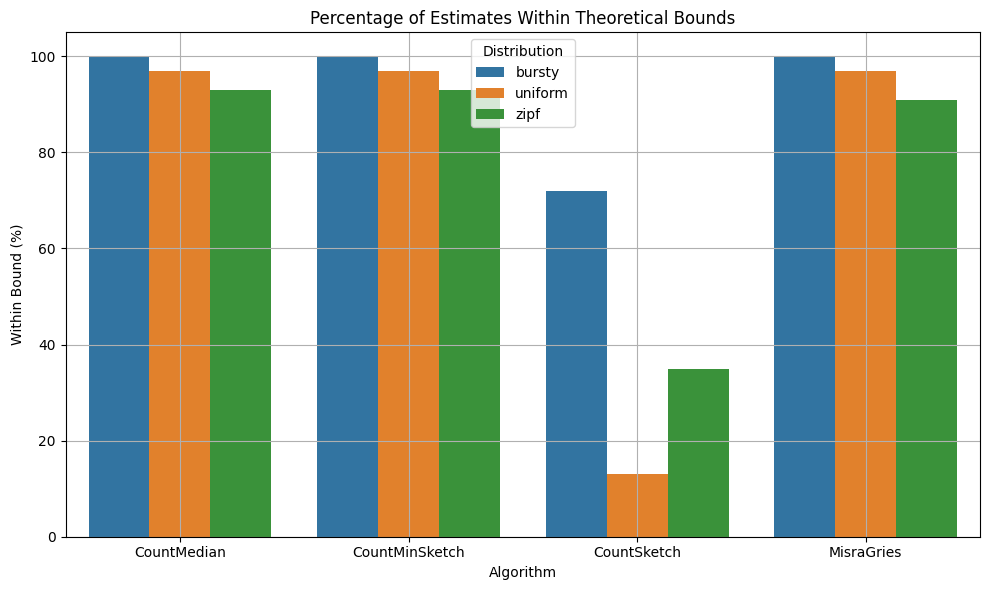

In [64]:
summary_df = full_df.groupby(["Algorithm", "Distribution"])["WithinBound"].agg(
    NumItems="count",
    NumWithinBound="sum"
).reset_index()

summary_df["%WithinBound"] = (summary_df["NumWithinBound"] / summary_df["NumItems"]) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Algorithm", y="%WithinBound", hue="Distribution")
plt.title("Percentage of Estimates Within Theoretical Bounds")
plt.ylim(0, 105)
plt.ylabel("Within Bound (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
out_of_bound_df = full_df[full_df['WithinBound'] == 0]
print(out_of_bound_df['Algorithm'].unique())

['CountSketch']


In [52]:
print(full_df.groupby("Algorithm")["WithinBound"].mean())

Algorithm
CountMedian       1.00
CountMinSketch    1.00
CountSketch       0.72
MisraGries        1.00
Name: WithinBound, dtype: float64


In [53]:
summary = full_df.groupby("Algorithm")["WithinBound"].mean().reset_index()
summary["% Within Bound"] = summary["WithinBound"] * 100
summary.drop(columns="WithinBound", inplace=True)
summary

,Algorithm,% Within Bound
0,CountMedian,100.0
1,CountMinSketch,100.0
2,CountSketch,72.0
3,MisraGries,100.0


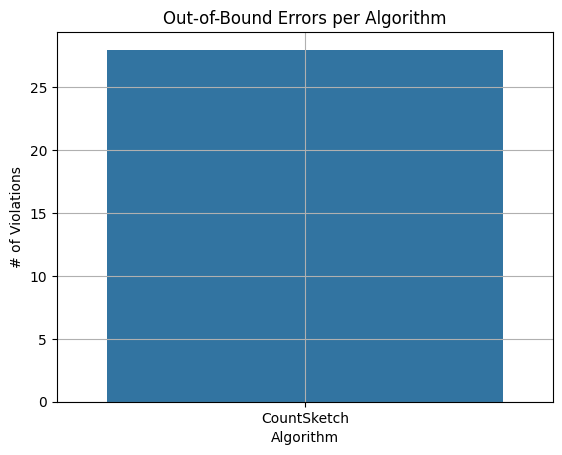

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

out_of_bound_counts = full_df[~full_df["WithinBound"]].groupby("Algorithm").size().reset_index(name="OutOfBoundCount")
sns.barplot(data=out_of_bound_counts, x="Algorithm", y="OutOfBoundCount")
plt.title("Out-of-Bound Errors per Algorithm")
plt.ylabel("# of Violations")
plt.grid(True)
plt.show()

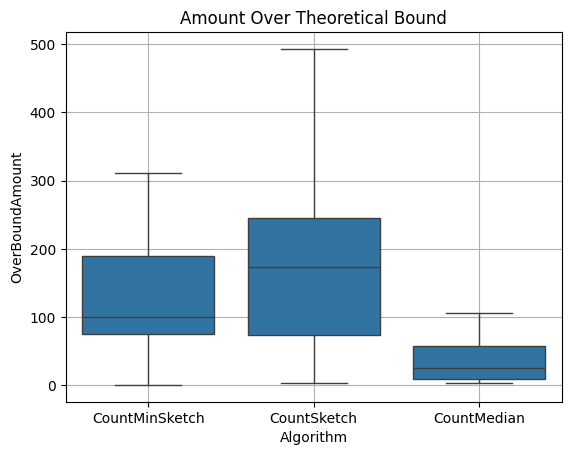

In [39]:
full_df["OverBoundAmount"] = full_df["AbsError"] - full_df["TheoreticalBound"]
sns.boxplot(data=full_df[~full_df["WithinBound"]], x="Algorithm", y="OverBoundAmount")
plt.title("Amount Over Theoretical Bound")
plt.grid(True)
plt.show()

In [40]:
violations = full_df[~full_df["WithinBound"]]
frequent_offenders = violations["Item"].value_counts().head(10)
print(frequent_offenders)

Item
90    3
3     3
26    3
23    3
86    3
69    3
32    3
18    3
63    2
72    2
Name: count, dtype: int64


In [3]:
import pandas as pd

errors_df = pd.DataFrame.from_dict(results['CountMinSketch']['errors'], orient='index',
                                   columns=['True', 'Estimate', 'AbsError', 'RelError'])
print(errors_df.sort_values('AbsError', ascending=False).head(10))

print(f"\nRuntime: {results['CountMinSketch']['runtime']:.4f} seconds")
print(f"Mean Abs Error: {errors_df['AbsError'].mean():.2f}")
print(f"Mean Rel Error: {errors_df['RelError'].mean():.2f}")


    True  Estimate  AbsError  RelError
75    98       191        93   0.94898
41   106       106         0   0.00000
74    91        91         0   0.00000
95    98        98         0   0.00000
18    97        97         0   0.00000
50    96        96         0   0.00000
63    97        97         0   0.00000
72    99        99         0   0.00000
51    92        92         0   0.00000
40   107       107         0   0.00000

Runtime: 0.0931 seconds
Mean Abs Error: 0.93
Mean Rel Error: 0.01


In [4]:
import pandas as pd

def summarize_errors(errors_dict, algo_name):
    df = pd.DataFrame.from_dict(errors_dict, orient='index',
                                 columns=['True', 'Estimate', 'AbsError', 'RelError'])
    print(f"---{algo_name} Summary---")
    print("-" * 40)
    print(df.sort_values('AbsError', ascending=False).head(10))
    print(f"\nRuntime: {results[algo_name]['runtime']:.4f} seconds")
    print(f"Mean Abs Error: {df['AbsError'].mean():.2f}")
    print(f"Mean Rel Error: {df['RelError'].mean():.2f}\n")
    return df


In [5]:
df_mg = summarize_errors(results["MisraGries"]["errors"], "MisraGries")
df_cms = summarize_errors(results["CountMinSketch"]["errors"], "CountMinSketch")
df_cs  = summarize_errors(results["CountSketch"]["errors"], "CountSketch")
df_cm = summarize_errors(results["CountMedian"]["errors"], "CountMedian")

---MisraGries Summary---
----------------------------------------
    True  Estimate  AbsError  RelError
73   126         0       126       1.0
84   120         0       120       1.0
58   118         0       118       1.0
17   116         0       116       1.0
98   116         0       116       1.0
78   115         0       115       1.0
60   115         0       115       1.0
38   115         0       115       1.0
88   115         0       115       1.0
11   114         0       114       1.0

Runtime: 0.0068 seconds
Mean Abs Error: 100.00
Mean Rel Error: 1.00

---CountMinSketch Summary---
----------------------------------------
    True  Estimate  AbsError  RelError
75    98       191        93   0.94898
41   106       106         0   0.00000
74    91        91         0   0.00000
95    98        98         0   0.00000
18    97        97         0   0.00000
50    96        96         0   0.00000
63    97        97         0   0.00000
72    99        99         0   0.00000
51    92      

In [6]:
df_mg["Algorithm"] = "MisraGries"
df_cms["Algorithm"] = "CountMinSketch"
df_cs["Algorithm"] = "CountSketch"
df_cm["Algorithm"] = "CountSketchMedian"

# Combine into one big DataFrame
all_errors_df = pd.concat([df_mg, df_cms, df_cs, df_cm])
all_errors_df.reset_index(inplace=True)
all_errors_df.rename(columns={"index": "Item"}, inplace=True)

# Save to CSV if needed
all_errors_df.to_csv("../results/all_error_summary.csv", index=False)


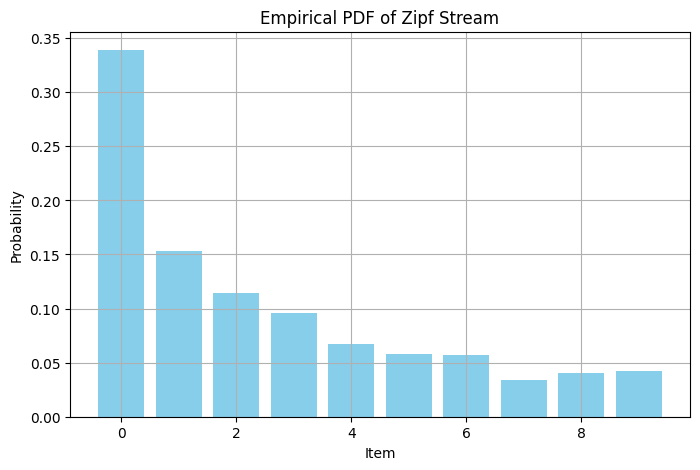

In [ ]:
test = generate_stream('zipf')
counts = Counter(test)
total = sum(counts.values())
pdf = {item: freq / total for item, freq in counts.items()}

pdf = dict(sorted(pdf.items()))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(pdf.keys(), pdf.values(), color='skyblue')
plt.title("Empirical PDF of Zipf Stream")
plt.xlabel("Item")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

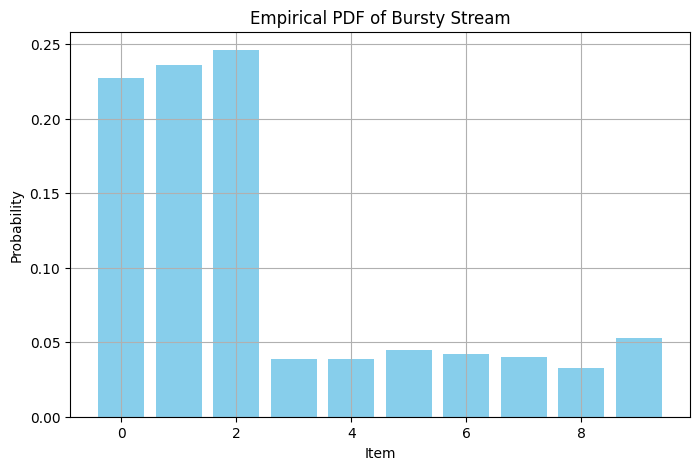

In [76]:
test = generate_stream('bursty')
counts = Counter(test)
total = sum(counts.values())
pdf = {item: freq / total for item, freq in counts.items()}

# Sort by item ID (optional)
pdf = dict(sorted(pdf.items()))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(pdf.keys(), pdf.values(), color='skyblue')
plt.title("Empirical PDF of Bursty Stream")
plt.xlabel("Item")
plt.ylabel("Probability")
plt.grid(True)
plt.show()